This notebook contains an exploratory data analysis of six CSV files containing taxi GPS data and start times collected over a six-month period. The analysis focuses on understanding the data structure and quality, detecting outliers, and examining the usage patterns of different taxi bases along with their temporal frequency distributions. These insights serve as a foundation for developing predictive models to forecast demand in key clusters within the city.

# Imports

In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.cluster import MiniBatchKMeans
import folium
from folium.plugins import MarkerCluster
import pyproj
from pyproj import Transformer
from sklearn.metrics import silhouette_score
import os

# EDA of the Taxi Transportation Data

## 1. Loading the data


In [22]:
# Load the data for april 2014
csv_path_apr = "../data/raw/data-apr14.csv"
data_apr_14 = pd.read_csv(csv_path_apr)

# Load the data for may 2014
csv_path_may = "../data/raw/data-may14.csv"
data_may_14 = pd.read_csv(csv_path_may)

# Load the data for june 2014
csv_path_jun = "../data/raw/data-jun14.csv"
data_jun_14 = pd.read_csv(csv_path_jun)

# Load the data for july 2014
csv_path_jul = "../data/raw/data-jul14.csv"
data_jul_14 = pd.read_csv(csv_path_jul)

# Load the data for august 2014
csv_path_aug = "../data/raw/data-aug14.csv"
data_aug_14 = pd.read_csv(csv_path_aug)

# Load the data for september 2014
csv_path_sep = "../data/raw/data-sep14.csv"
data_sep_14 = pd.read_csv(csv_path_sep)

In [23]:
# Taking a look at the lenghts of the dataframes
print(len(data_apr_14))
print(len(data_may_14))
print(len(data_jun_14))
print(len(data_jul_14))
print(len(data_aug_14))
print(len(data_sep_14))

564516
652435
663844
796121
829275
1028136


In [24]:
# Taking a look at the data structure
data_apr_14.head()

,Date/Time,Lat,Lon,Base
0,4/1/2014 0:11:00,40.7690,-73.9549,B02512
1,4/1/2014 0:17:00,40.7267,-74.0345,B02512
2,4/1/2014 0:21:00,40.7316,-73.9873,B02512
3,4/1/2014 0:28:00,40.7588,-73.9776,B02512
4,4/1/2014 0:33:00,40.7594,-73.9722,B02512


In [25]:
# Analysing the datatypes of the contained columns
data_apr_14.dtypes

Date/Time     object
Lat          float64
Lon          float64
Base          object
dtype: object

In [26]:
# Renaming the "Date/Time"- column in "Messagetimestamp"
# Converting the column "Messagetimestamp to datetime-object
# Converting the column "BASE" to string

# Creating a dictionary, that contains all monthly dfs
monthly_dfs = {
    "apr": data_apr_14,
    "may": data_may_14,
    "jun": data_jun_14,
    "jul": data_jul_14,
    "aug": data_aug_14,
    "sep": data_sep_14
}

# Looping through all monthly dfs and applying the changes
for name, df in monthly_dfs.items():
    df.rename(columns={"Date/Time": "messagetimestamp"}, inplace=True)
    df["messagetimestamp"] = pd.to_datetime(df["messagetimestamp"])
    df["Base"] = df["Base"].astype(str)

In [27]:
# Checking for NaN values in each monthly DataFrame
for name, df in monthly_dfs.items():
    nan_count = df.isna().sum()
    total_nans = nan_count.sum()
    print(f"{name.upper()}: {total_nans} NaN values")
    if total_nans > 0:
        print(nan_count[nan_count > 0])

APR: 0 NaN values
MAY: 0 NaN values
JUN: 0 NaN values
JUL: 0 NaN values
AUG: 0 NaN values
SEP: 0 NaN values


## 2. Visualizing the Data to Detect Patterns

### 2.1. Plotting the Hourly Demand by Weekday for each Month separately

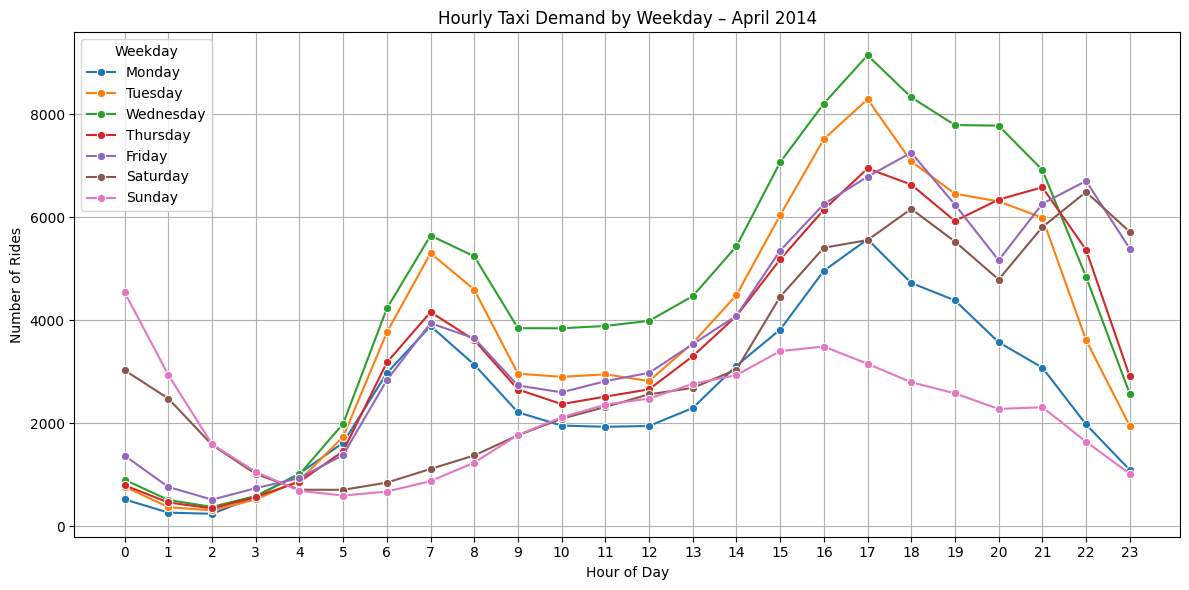

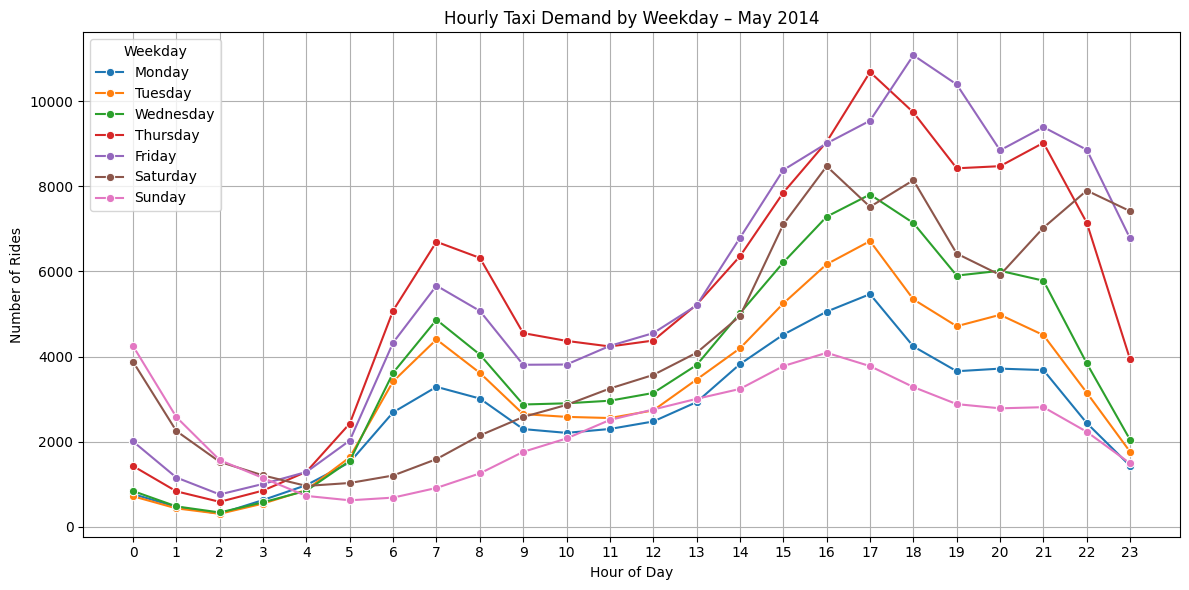

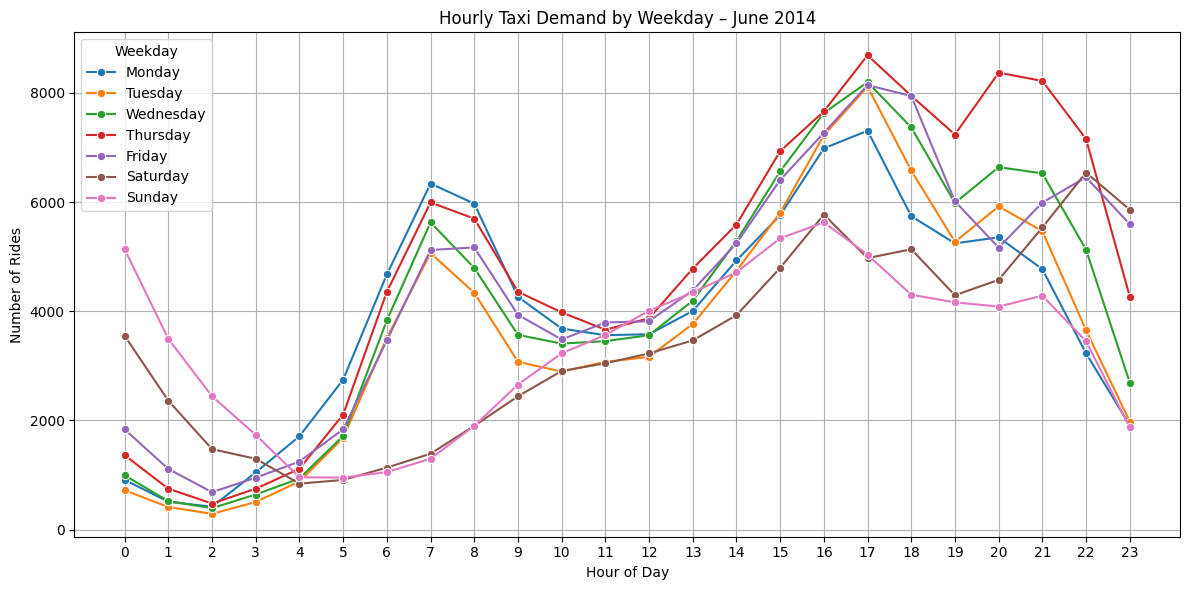

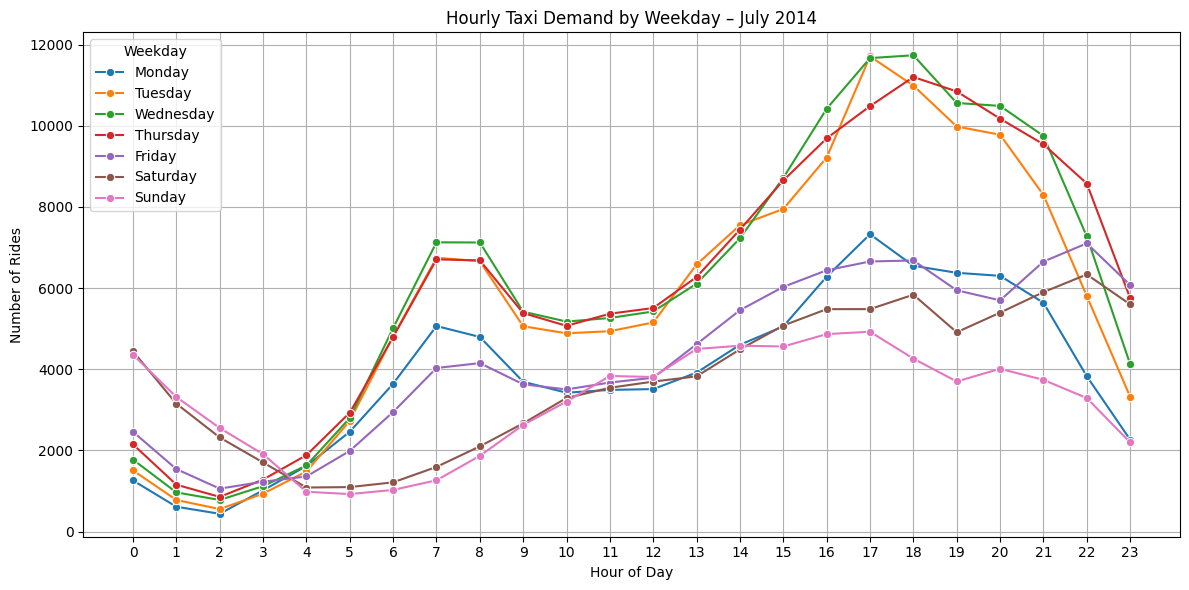

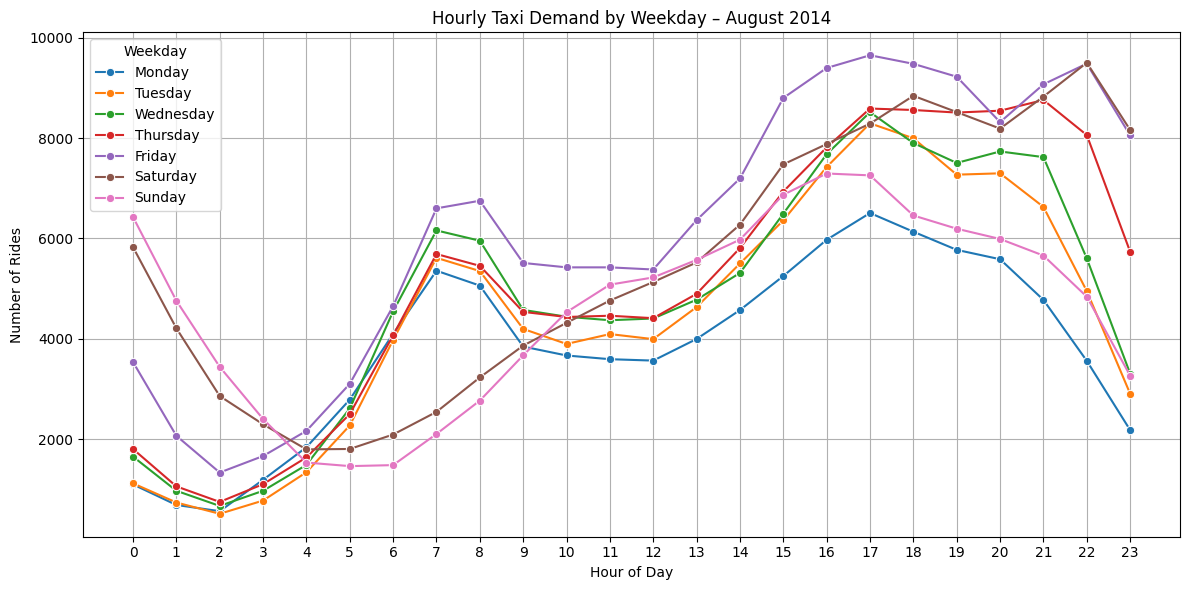

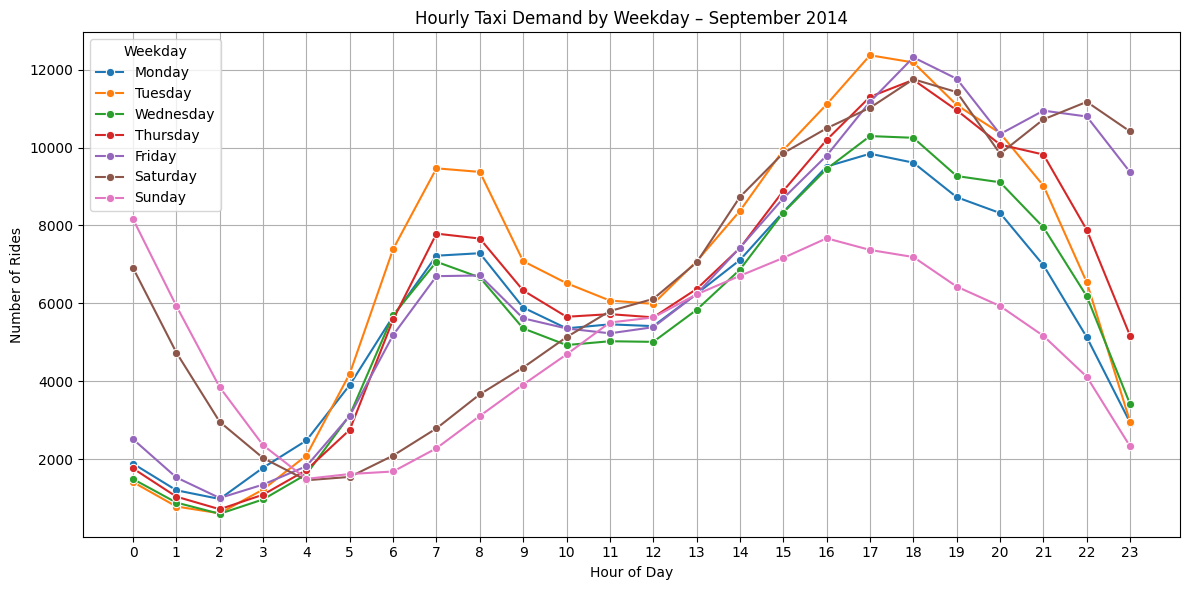

In [28]:
# Mapping for the names of the months
month_names = {
    'apr': 'April',
    'may': 'May',
    'jun': 'June',
    'jul': 'July',
    'aug': 'August',
    'sep': 'September'
}

# Iterating over the monthly-dfs
for name, df in monthly_dfs.items():

    # Temporary df to avoid changes in the original dfs
    temp_df = df.copy()

    # Extracting the hour and weekday out of the column "messagetimestamp"
    temp_df['hour'] = temp_df['messagetimestamp'].dt.hour
    temp_df['weekday'] = temp_df['messagetimestamp'].dt.day_name()

    # Grouping by weekday and hour
    hourly_demand = temp_df.groupby(['weekday', 'hour']).size().reset_index(name='ride_count')

    # Correct order for the weekdays
    weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
    hourly_demand['weekday'] = pd.Categorical(hourly_demand['weekday'], categories=weekday_order, ordered=True)

    # Plot
    plt.figure(figsize=(12, 6))
    sns.lineplot(data=hourly_demand, x='hour', y='ride_count', hue='weekday', marker='o')

    # Inserting the name of the month in the plot
    month_label = month_names.get(name[:3].lower(), name)
    plt.title(f'Hourly Taxi Demand by Weekday – {month_label} 2014')

    plt.xlabel('Hour of Day')
    plt.ylabel('Number of Rides')
    plt.xticks(range(0, 24))
    plt.legend(title='Weekday')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

### 2.2. Plotting the Hourly Demand by Weekday (April - September 2014)

In [9]:
# Combining the dataframes into one dataframe, to make the further analysis easier
combined_data = pd.concat(
    [data_apr_14, data_may_14, data_jun_14, data_jul_14, data_aug_14, data_sep_14], 
    ignore_index=True
)
combined_data.head()

,messagetimestamp,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512


In [17]:
len(combined_data)

4534327

In [10]:
# Saving the combined dataframe
# Defining the path to save the files
save_path = '/Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/data/interim'

# Define file paths
csv_file = os.path.join(save_path, 'combined_data.csv')
pickle_file = os.path.join(save_path, 'combined_data.pkl')

# Save as CSV
combined_data.to_csv(csv_file, index=False)
print(f"DataFrame saved as CSV: {csv_file}")

# Save as Pickle (faster save/load, keeps data types)
combined_data.to_pickle(pickle_file)
print(f"DataFrame saved as Pickle: {pickle_file}")

DataFrame saved as CSV: /Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/data/interim/combined_data.csv
DataFrame saved as Pickle: /Users/sandragedig/Documents/Dokumente/Data_Science/Semester_6/Model_Engineering_Case_Study/public_transport_forecast/data/interim/combined_data.pkl


In [11]:
# Taking a look at the length of the combined dataset
combined_data

,messagetimestamp,Lat,Lon,Base
0,2014-04-01 00:11:00,40.7690,-73.9549,B02512
1,2014-04-01 00:17:00,40.7267,-74.0345,B02512
2,2014-04-01 00:21:00,40.7316,-73.9873,B02512
3,2014-04-01 00:28:00,40.7588,-73.9776,B02512
4,2014-04-01 00:33:00,40.7594,-73.9722,B02512
...,...,...,...,...
4534322,2014-09-30 22:57:00,40.7668,-73.9845,B02764
4534323,2014-09-30 22:57:00,40.6911,-74.1773,B02764
4534324,2014-09-30 22:58:00,40.8519,-73.9319,B02764
4534325,2014-09-30 22:58:00,40.7081,-74.0066,B02764


As we can see, the dataset is very large. We have to keep this in mind when choosing an appropriate clustering method.

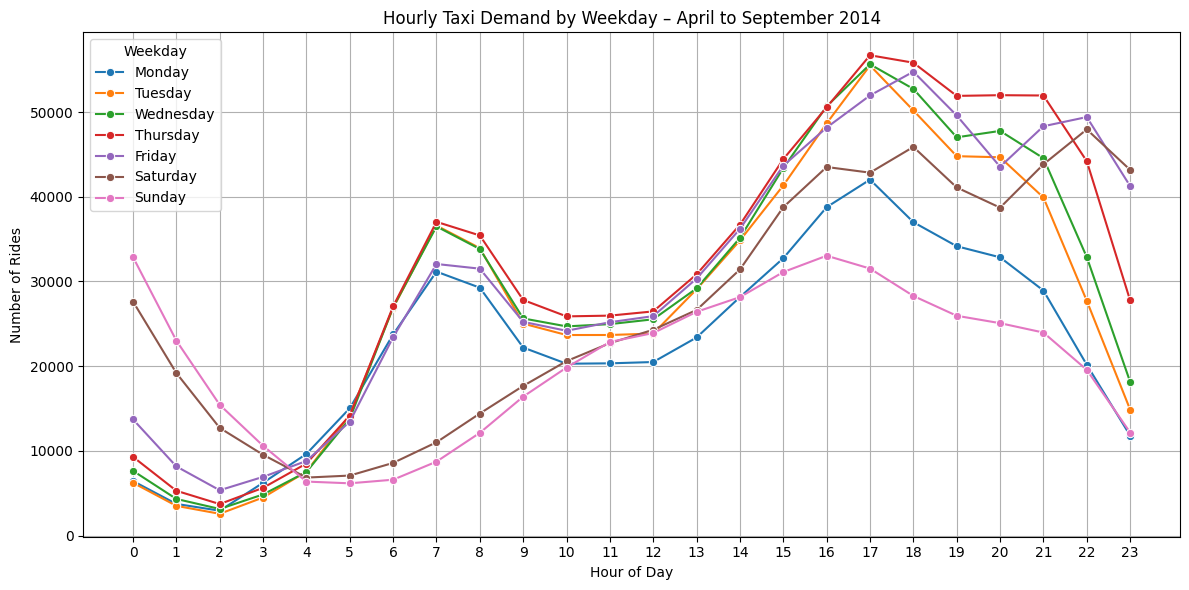

In [12]:
# Creating a temporary dataframe
temp_df = combined_data.copy()

# Extracting the hour and the weekday
temp_df['hour'] = temp_df['messagetimestamp'].dt.hour
temp_df['weekday'] = temp_df['messagetimestamp'].dt.day_name()

# Grouping by weekday and hour
hourly_demand = temp_df.groupby(['weekday', 'hour']).size().reset_index(name='ride_count')

# Sorting the weekends in the right order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
hourly_demand['weekday'] = pd.Categorical(hourly_demand['weekday'], categories=weekday_order, ordered=True)

# Plot
plt.figure(figsize=(12, 6))
sns.lineplot(data=hourly_demand, x='hour', y='ride_count', hue='weekday', marker='o')

plt.title('Hourly Taxi Demand by Weekday – April to September 2014')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.legend(title='Weekday')
plt.grid(True)
plt.tight_layout()
plt.show()

#### Key Findings:

- Weekday pattern (monday till friday):
    - morning demand peak around 7-9 AM (commuter traffic)
    - stronger evening peak between 4-7 PM
    - strong demand on friday evening (likely because of people going out)

- Saturday:
    - shift in demand to later hours in the day (no commuter traffic)
    - peak demand occurs in the evening (6-10 PM)
    - high demand persits until late at night

- Sunday: 
    - lower and flatter demant pattern throughout the day
    - no strong morning or evening peak (no commuter traffic)

- Reduced weekday variation in taxi-usage in July:
    - the hourly differences between weekdays and weekends are much less pronounced
    - this effect could be due to the summer vacation that leads to lesss commuter traffic
    - the tourism could be responsible for the consistent all-day demand across all weekdays
    
Conclusion: Big difference between weekday demands and weekend demands. 
On the weekend, the demand is not driven bei commuting. 
The weekend pattern instead reflects leisure and social behavior.

### 2.3. Total Taxi Rides per Weekday (April–September 2014)

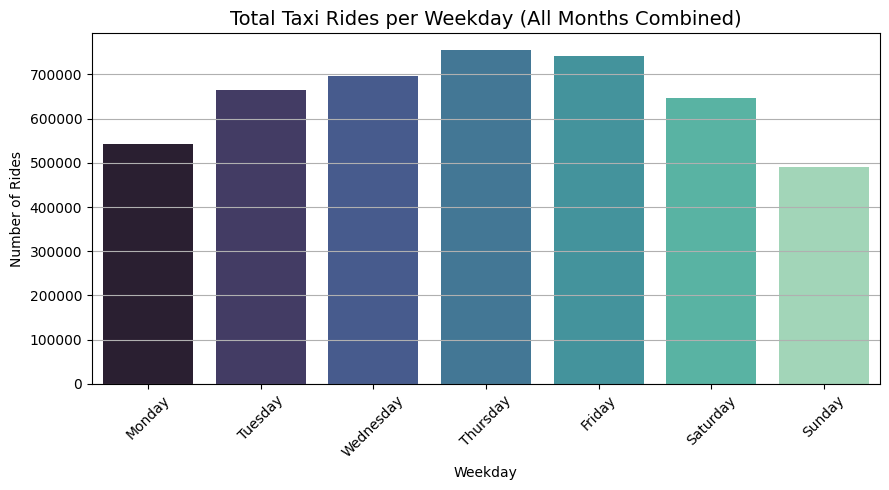

In [13]:
# Plotting the total taxi rides per weekday over the duration of half a year
temp_df = combined_data.copy()

# Extracting the weekdays
temp_df['weekday'] = temp_df['messagetimestamp'].dt.day_name()

# Sorting the weekdays in the right order
weekday_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
temp_df['weekday'] = pd.Categorical(temp_df['weekday'], categories=weekday_order, ordered=True)

# Aggregation the taxi rides per weekday
weekday_counts = temp_df['weekday'].value_counts().sort_index()

# Plot
plt.figure(figsize=(9, 5))
sns.barplot(x=weekday_counts.index, y=weekday_counts.values, hue=weekday_counts.index, palette='mako', legend=False)

plt.title('Total Taxi Rides per Weekday (All Months Combined)', fontsize=14)
plt.xlabel('Weekday')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

#### Key Findings:

- Sunday has the fewest rides, indicating low weekend demand.
- Monday and Saturday also show relatively low ride counts.
- Thursday, Friday, and Wednesday have the highest taxi demand.
- Midweek and end-of-week peaks suggest commuter and social activity patterns.

### 2.4. Daily Ride Counts (April - September 2014)

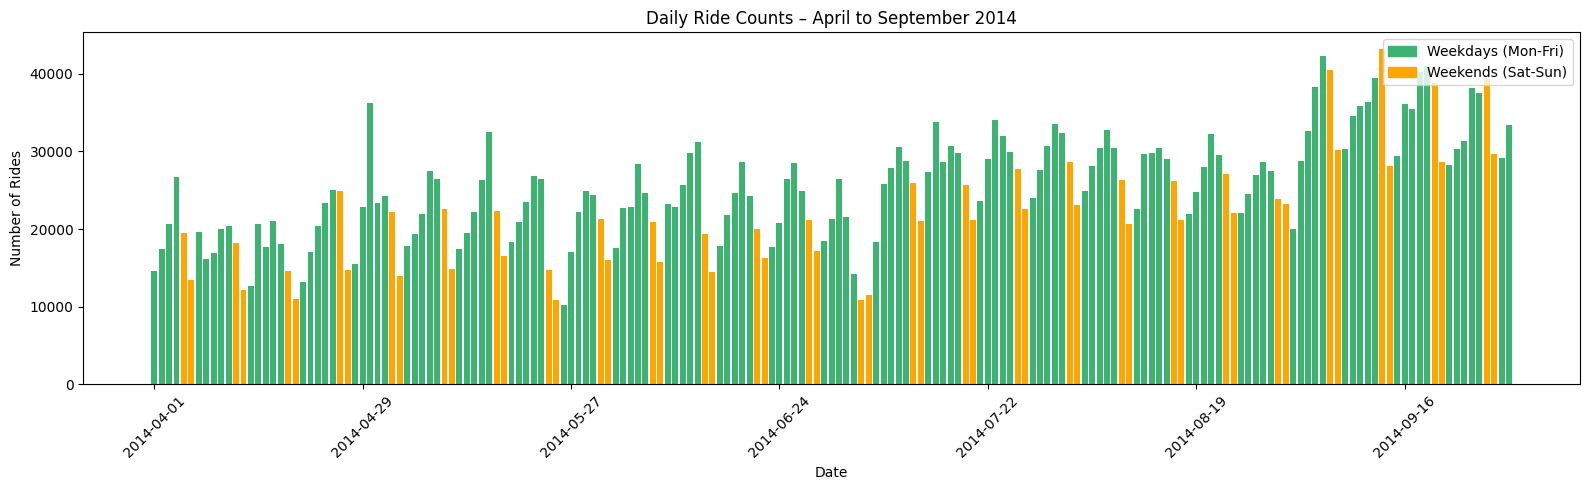

In [14]:
temp_df = combined_data.copy()
temp_df["day"] = temp_df["messagetimestamp"].dt.date

# Number of Rides per Day
daily_counts = temp_df.groupby("day").size().reset_index(name='ride_count')

# Finding the weekday for each Date
daily_counts['weekday'] = pd.to_datetime(daily_counts['day']).dt.dayofweek  # 0=Mo, ..., 6=So

# Colours depending on the weekday
colors = daily_counts['weekday'].apply(lambda x: 'orange' if x >= 5 else 'mediumseagreen')

plt.figure(figsize=(16, 5))
plt.bar(daily_counts['day'].astype(str), daily_counts['ride_count'], color=colors)

plt.title("Daily Ride Counts – April to September 2014")
plt.xlabel("Date")
plt.ylabel("Number of Rides")

# Only show the date ever 28 days
dates = daily_counts['day']
tick_positions = [i for i in range(0, len(dates), 28)]
tick_labels = [dates.iloc[i].strftime("%Y-%m-%d") for i in tick_positions]
plt.xticks(ticks=tick_positions, labels=tick_labels, rotation=45)

# Filling in a legend to explain the colours
weekday_patch = mpatches.Patch(color='mediumseagreen', label='Weekdays (Mon-Fri)')
weekend_patch = mpatches.Patch(color='orange', label='Weekends (Sat-Sun)')
plt.legend(handles=[weekday_patch, weekend_patch], loc='upper right')

plt.tight_layout()
plt.show()

#### Key Findings:
- Taxi demand increases steadily from April to September.
- This rise may be explained by:
    - Higher tourist volumes during summer months.
    - Warmer weather encouraging more taxi usage.
    - Increased weekend leisure activities and events in late summer.
    - Saturdays becoming more prominent due to greater social outings in August and September.

### 2.5. Number of Taxi Rides per Month (April - September 2014)

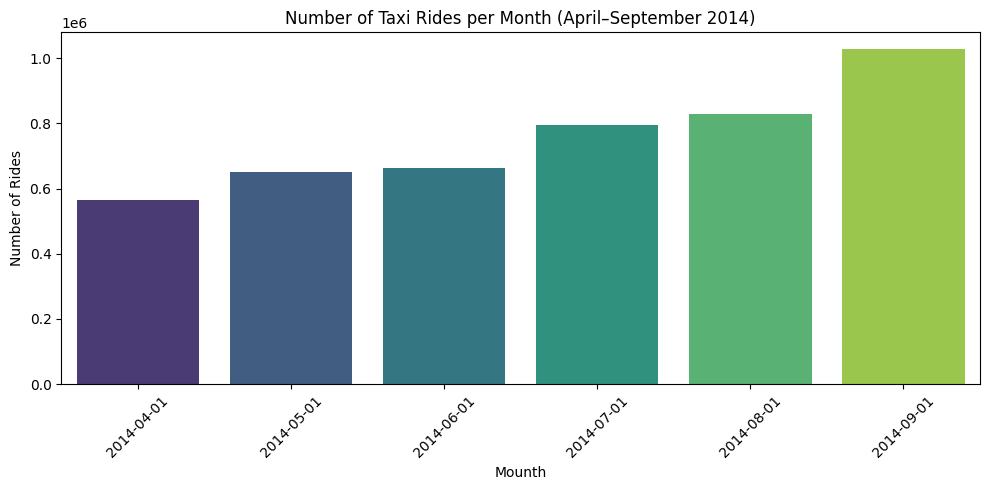

In [15]:
# Create a temporary copy of the DataFrame
temp_df = combined_data.copy()

# Create a temporary 'month' column (first day of the month)
temp_df['month'] = temp_df['messagetimestamp'].dt.to_period('M').dt.to_timestamp()

# Count the rides for each month
monthly_counts = temp_df.groupby('month').size().reset_index(name='ride_count')

# Plot
plt.figure(figsize=(10, 5))
sns.barplot(x='month', y='ride_count', data=monthly_counts, hue='month', palette='viridis', legend=False)

plt.title('Number of Taxi Rides per Month (April–September 2014)')
plt.xlabel('Mounth')
plt.ylabel('Number of Rides')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


#### Key Findings:
- the demand rises with every month between april and september
- the month with the biggest demand is september

### 2.6. Modelling the Trend of the Taxi Rides during April and September 2014 with Regression


Regression results for degree 1 (Linear):
                            OLS Regression Results                            
Dep. Variable:             ride_count   R-squared:                       0.459
Model:                            OLS   Adj. R-squared:                  0.456
Method:                 Least Squares   F-statistic:                     153.8
Date:                Wed, 23 Jul 2025   Prob (F-statistic):           5.80e-26
Time:                        13:35:52   Log-Likelihood:                -1824.6
No. Observations:                 183   AIC:                             3653.
Df Residuals:                     181   BIC:                             3660.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const    

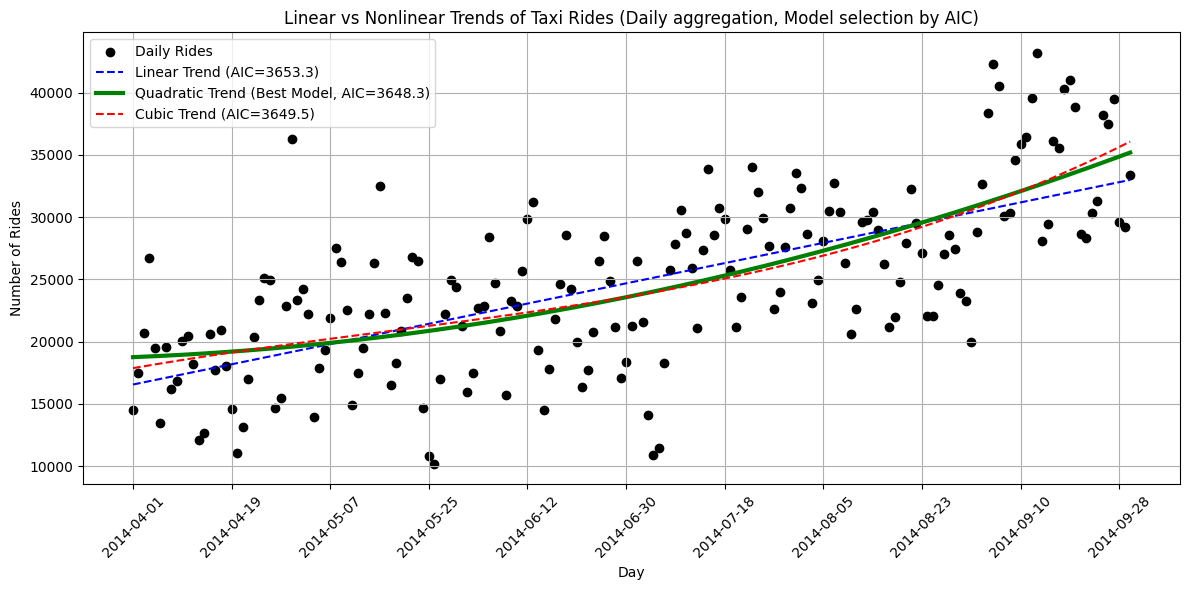

In [16]:
# Function to calculate AIC (if you want to use it explicitly)
def calculate_aic(n, rss, k):
    return n * np.log(rss / n) + 2 * k

# Prepare your data with daily aggregation
daily_counts = combined_data.copy()
daily_counts['day'] = daily_counts['messagetimestamp'].dt.to_period('D').dt.to_timestamp()
daily_counts = daily_counts.groupby('day').size().reset_index(name='ride_count')

daily_counts['day_num'] = range(len(daily_counts))
X = daily_counts[['day_num']]
y = daily_counts['ride_count']

plt.figure(figsize=(12, 6))
plt.scatter(X, y, color='black', label='Daily Rides')

results = []

for degree, color, label in [(1, 'blue', 'Linear'), (2, 'green', 'Quadratic'), (3, 'red', 'Cubic')]:
    # Create polynomial features
    poly = PolynomialFeatures(degree)
    X_poly = poly.fit_transform(X)
    
    # Add constant for intercept (required by statsmodels)
    X_poly_sm = sm.add_constant(X_poly)
    
    # Fit the OLS model
    model = sm.OLS(y, X_poly_sm).fit()
    
    # Predict
    y_pred = model.predict(X_poly_sm)
    
    # Calculate RSS (optional)
    rss = np.sum((y - y_pred) ** 2)
    n = len(y)
    k = X_poly_sm.shape[1]  # number of parameters including intercept
    aic = model.aic  # statsmodels calculates AIC automatically
    
    results.append((degree, aic, color, label, y_pred, model))
    
    # Print regression summary with p-values, coefficients, etc.
    print(f"\nRegression results for degree {degree} ({label}):")
    print(model.summary())

# Find best model by lowest AIC
best_model = min(results, key=lambda x: x[1])
best_degree, best_aic, best_color, best_label, best_pred, best_sm_model = best_model

# Plot all models, highlight best one
for degree, aic, color, label, y_pred, model in results:
    if degree == best_degree:
        plt.plot(X['day_num'], y_pred, color=color,
                 label=f'{label} Trend (Best Model, AIC={aic:.1f})', linewidth=3)
    else:
        plt.plot(X['day_num'], y_pred, color=color,
                 label=f'{label} Trend (AIC={aic:.1f})', linestyle='--')

plt.xticks(ticks=X['day_num'][::max(len(X)//10,1)], labels=daily_counts['day'].dt.strftime('%Y-%m-%d')[::max(len(X)//10,1)], rotation=45)
plt.xlabel('Day')
plt.ylabel('Number of Rides')
plt.title('Linear vs Nonlinear Trends of Taxi Rides (Daily aggregation, Model selection by AIC)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#### Key Findings:

- Taxi ride counts from April to September show a clear upward trend.
- AIC-based model comparison favors the quadratic trend, indicating the increase is nonlinear but not overly complex.
- The statistical significance of the quadratic term supports the presence of a meaningful curved pattern in the data.
- The nonlinear pattern likely reflects seasonal factors such as tourism and weather changes.
- Overall, demand rises steadily with some seasonal variation captured well by the quadratic model.
- It is likely that this quadratic trend represents part of a sinusoidal pattern, reflecting expected seasonal fluctuations in taxi ride demand caused by factors such as weather changes, holidays, and tourism cycles